In [1]:
# Core libraries
import numpy as np
import pandas as pd
import calendar
import os
import sys
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
# import altair_ally as aly

# Time series analysis
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, seasonal_decompose, SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Forecasting models
# from pmdarima import auto_arima

# ML models
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Preprocessing and pipelines
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

# Model evaluation and cross-validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import (
    train_test_split, TimeSeriesSplit, cross_validate, GridSearchCV
)
import shap 

# Optimization
from scipy.optimize import minimize

# sktime
from sktime.forecasting.model_selection import ForecastingGridSearchCV, ExpandingWindowSplitter
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon


/Users/alexwong/miniforge3/envs/sweet_pulse/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv('../data/modelling/train.csv', index_col=0, parse_dates=True)
test_df = pd.read_csv('../data/modelling/test.csv', index_col=0, parse_dates=True)

In [3]:
X_train = train_df.drop(columns=['total_sales_normalized'])
y_train = train_df['total_sales_normalized']

X_test = test_df.drop(columns=['total_sales_normalized'])
y_test = test_df['total_sales_normalized']

In [4]:
numerical_features = ['hours_opened', 'avg_temperature', 'rain', 'snow']
categorical_features = ['is_long_weekend', 'is_HCF', 'season', 'day_of_week', 'is_holiday']
category_orders = [
    [False, True],  # is_long_weekend
    [False, True],  # is_HCF
    ['Winter', 'Spring', 'Summer', 'Fall'],  # season
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],  # day_of_week
    [False, True]  # is_holiday
]
drop_features = ['total_sales_normalized', 'item_B_sales', 'item_C_sales']

preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', categories=category_orders), categorical_features),
    (StandardScaler(), numerical_features),
    ("drop", drop_features)
)


xgb = XGBRegressor(random_state=123)
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', categories=category_orders), categorical_features),
    (StandardScaler(), numerical_features)
)

xgb_pipe = make_pipeline(preprocessor, xgb)

In [5]:
xgb_pipe.fit(X_train, y_train)
y_pred = xgb_pipe.predict(X_test)
y_train_pred = xgb_pipe.predict(X_train)

In [6]:
y_train_for_plot = pd.DataFrame(y_train).assign(label='train')
y_test_for_plot = pd.DataFrame(y_test).assign(label='test')
lr_pred_for_plot = pd.DataFrame(y_pred, columns=['total_sales_normalized'], index=y_test.index).assign(label='test_prediction')
y_train_pred_for_plot = pd.DataFrame(y_train_pred, columns=['total_sales_normalized'], index=y_train.index).assign(label='train_prediction')

custom_colors = {
    'train': '#1f77b4',
    'test': '#d62728',
    'test_prediction': '#8bc34a',
    'train_prediction': '#8bc34a'
}

xgb_plot_fig = px.line(pd.concat((y_train_for_plot, y_test_for_plot, lr_pred_for_plot, y_train_pred_for_plot)), 
        y="total_sales_normalized",
        color='label', 
        title='Prediction results - XGB',
        color_discrete_map=custom_colors
        )

xgb_plot_fig.show()

In [7]:
mean_absolute_error(y_test, y_pred)

335.5083554687499

In [8]:
pred_results = test_df.copy()
pred_results['y_pred'] = y_pred
pred_results['prediction_error'] = pred_results['y_pred'] - pred_results['total_sales_normalized'] 

mae_grouped_df = pred_results.groupby('day_of_week')[['total_sales_normalized', 'y_pred', 'prediction_error']].mean().round(2)
mae_grouped_df['error_percentage'] = (mae_grouped_df['prediction_error'] / mae_grouped_df['total_sales_normalized']).round(3)
mae_grouped_df.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

,total_sales_normalized,y_pred,prediction_error,error_percentage
day_of_week,,,,
Monday,6434.42,6751.899902,317.48,0.049
Tuesday,6239.25,6256.399902,17.15,0.003
Wednesday,6465.93,6403.919922,-62.01,-0.010
Thursday,6700.23,6769.379883,69.15,0.010
Friday,8325.26,7826.790039,-498.46,-0.060
Saturday,8966.42,8737.580078,-228.83,-0.026
Sunday,8593.57,8224.610352,-368.96,-0.043


In [9]:
trained_xgb = xgb_pipe.named_steps['xgbregressor']
trained_preprocessor = xgb_pipe.named_steps['columntransformer']

columns = (xgb_pipe.named_steps['columntransformer'].named_transformers_['onehotencoder'].get_feature_names_out().tolist() + 
            xgb_pipe.named_steps['columntransformer'].named_transformers_['standardscaler'].get_feature_names_out().tolist()) 

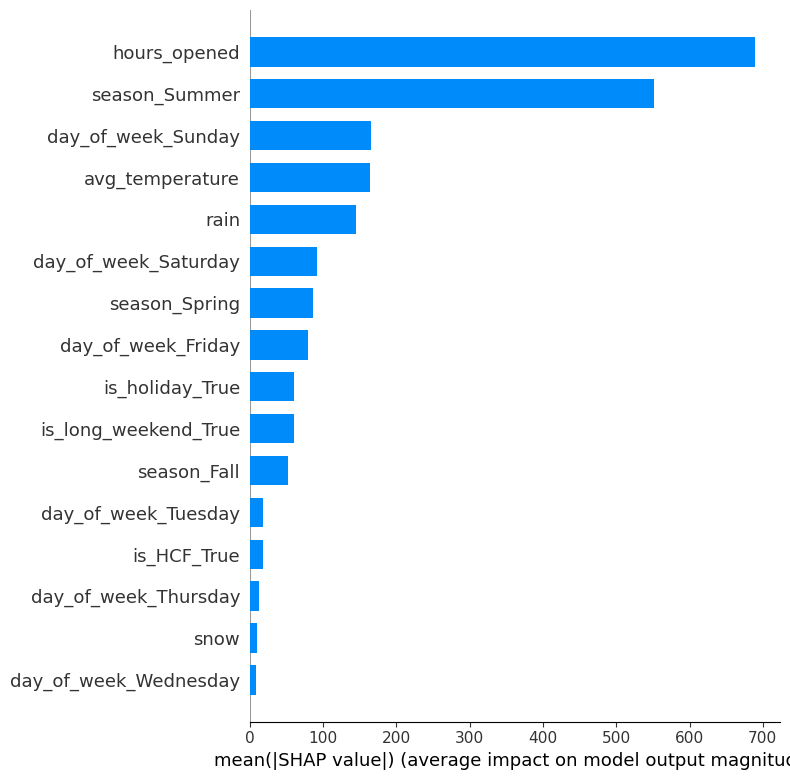

In [10]:
explainer = shap.TreeExplainer(trained_xgb)
observations = pd.DataFrame(trained_preprocessor.transform(X_train), columns=columns)
shap_values = explainer.shap_values(observations)
shap.summary_plot(shap_values, observations, plot_type='bar')

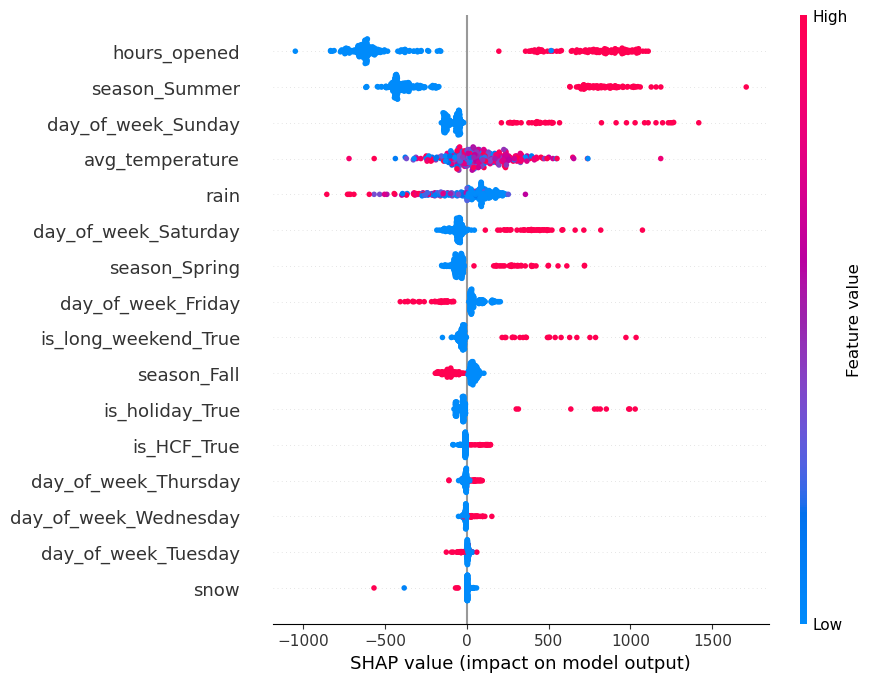

In [16]:
explanation = explainer(observations)
shap.plots.beeswarm(explanation, max_display=50)